In [808]:
%matplotlib inline

In [1074]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_importance

import optuna
from optuna.visualization import plot_optimization_history

from sklearn.metrics import (accuracy_score, make_scorer, f1_score, fbeta_score, roc_auc_score, precision_score, 
                                recall_score, classification_report, confusion_matrix, roc_curve, auc)

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

import pickle

In [13]:
# pip install optuna

# Analysis of [merged dataset](data/merged_ds.csv)

## EDA

In [810]:
merged_dataset = pd.read_csv("data/merged_ds.csv")
merged_dataset

,age,gender,chest_pain_type,blood_pressure,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,heart_disease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1358,68,M,NAP,144,193,1,Normal,141,N,3.4,Up,1
1359,57,M,NAP,130,131,0,Normal,115,Y,1.2,Up,1
1360,57,F,TA,130,236,0,LVH,174,N,0.0,Up,1
1361,38,M,ATA,138,175,0,Normal,173,N,0.0,Up,0


In [811]:
merged_dataset.shape

(1363, 12)

In [812]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1363 non-null   int64  
 1   gender            1363 non-null   object 
 2   chest_pain_type   1363 non-null   object 
 3   blood_pressure    1363 non-null   int64  
 4   cholesterol       1363 non-null   int64  
 5   high_blood_sugar  1363 non-null   int64  
 6   resting_ecg       1363 non-null   object 
 7   max_heart_rate    1363 non-null   int64  
 8   exercise_angina   1363 non-null   object 
 9   oldpeak           1363 non-null   float64
 10  st_slope          1363 non-null   object 
 11  heart_disease     1363 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 127.9+ KB


In [813]:
merged_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1363.0,53.646368,9.355735,28.0,47.0,54.0,60.0,77.0
blood_pressure,1363.0,131.809978,18.138029,0.0,120.0,130.0,140.0,200.0
cholesterol,1363.0,214.230374,97.236408,0.0,195.0,230.0,269.0,603.0
high_blood_sugar,1363.0,0.206897,0.405229,0.0,0.0,0.0,0.0,1.0
max_heart_rate,1363.0,141.876742,25.480771,60.0,123.0,144.0,161.0,202.0
oldpeak,1363.0,0.891343,1.070626,-2.6,0.0,0.6,1.5,6.2
heart_disease,1363.0,0.584006,0.493073,0.0,0.0,1.0,1.0,1.0


### Plot the distribution for the numerical columns

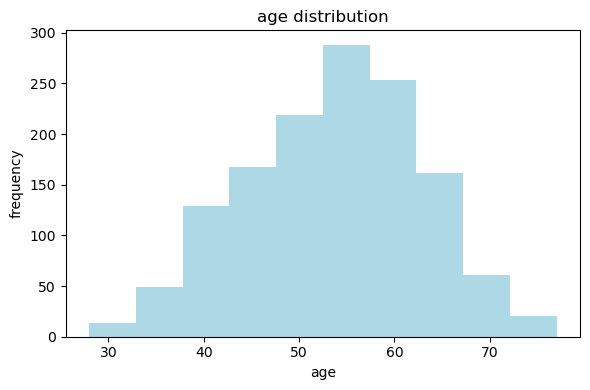

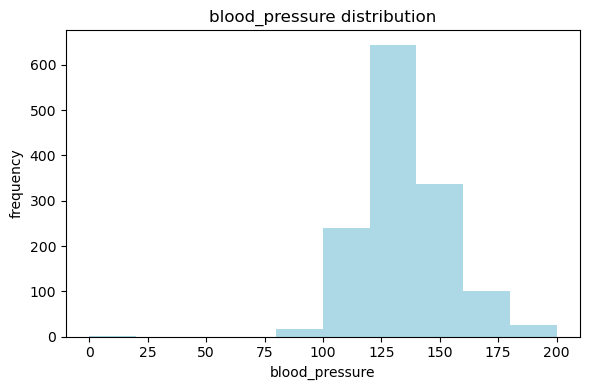

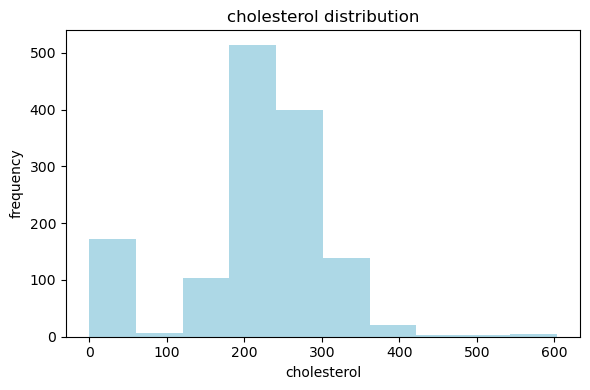

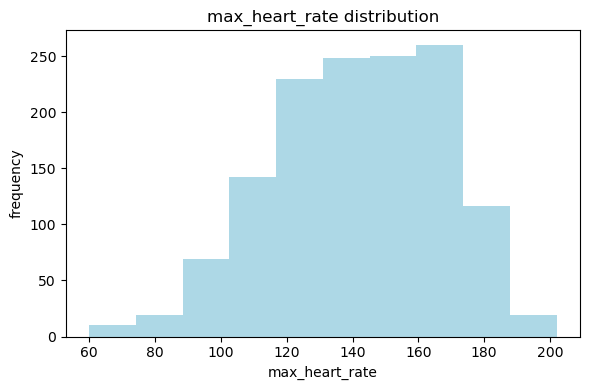

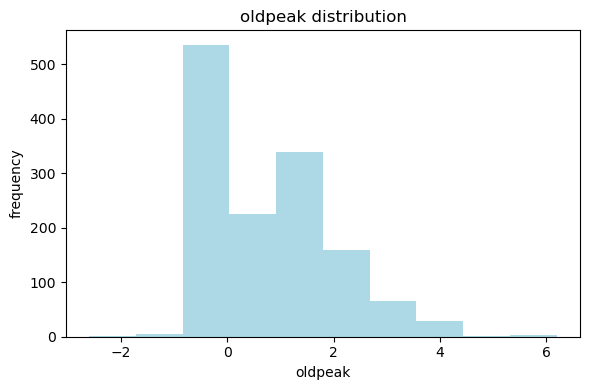

In [814]:
for column in merged_dataset[["age", "blood_pressure", "cholesterol", "max_heart_rate", "oldpeak"]]:
    plt.figure(figsize = (6, 4))

    plt.hist(merged_dataset[column], color = 'lightblue')
    plt.title(f'{column} distribution')
    plt.xlabel(column)
    plt.ylabel('frequency')

    plt.tight_layout()
    plt.show()

In [815]:
merged_dataset[merged_dataset.cholesterol == 0]

,age,gender,chest_pain_type,blood_pressure,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,heart_disease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [816]:
merged_dataset[merged_dataset.cholesterol == 0].heart_disease.value_counts()

heart_disease
1    152
0     20
Name: count, dtype: int64

In [817]:
heart_disease_1 = merged_dataset.loc[merged_dataset['heart_disease'] == 1].copy()
heart_disease_0 = merged_dataset.loc[merged_dataset['heart_disease'] == 0].copy()

# impute zero cholesterol values for heart_disease = 1
imputer_1 = SimpleImputer(strategy = 'mean', missing_values = 0)
heart_disease_1['cholesterol'] = imputer_1.fit_transform(heart_disease_1[['cholesterol']])

# impute missing cholesterol values for heart_disease = 0
imputer_0 = SimpleImputer(strategy = 'mean', missing_values = 0)
heart_disease_0['cholesterol'] = imputer_0.fit_transform(heart_disease_0[['cholesterol']])

dataset = pd.concat([heart_disease_1, heart_disease_0], ignore_index = True)

In [818]:
dataset[dataset.cholesterol == 0]

,age,gender,chest_pain_type,blood_pressure,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,heart_disease


In [819]:
dataset[dataset.blood_pressure == 0]

,age,gender,chest_pain_type,blood_pressure,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,heart_disease
245,55,M,NAP,0,249.507764,0,Normal,155,N,1.5,Flat,1


In [820]:
imp = SimpleImputer(strategy = 'mean', missing_values = 0)
dataset['blood_pressure'] = imp.fit_transform(dataset[['blood_pressure']])

In [405]:
'''
    I tried binning the oldpeak, but the performance was worse.
    ranges: (-inf, 1), [1, 2], (2, 3.5], (3.5, +inf)
'''

# bins = [float('-inf'), 1, 2, 3.5, float('inf')]
# labels = ['Normal', 'Mild', 'Severe', 'Critical']
# dataset['oldpeak'] = pd.cut(dataset['oldpeak'], bins = bins, labels = labels, right = True).astype('object')

### Bar plot for the categorical features

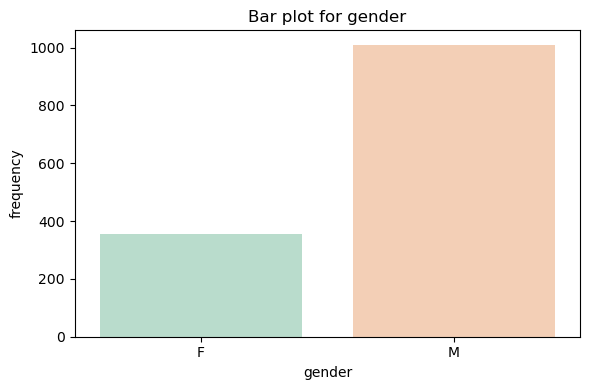

gender
M    1009
F     354
Name: count, dtype: int64


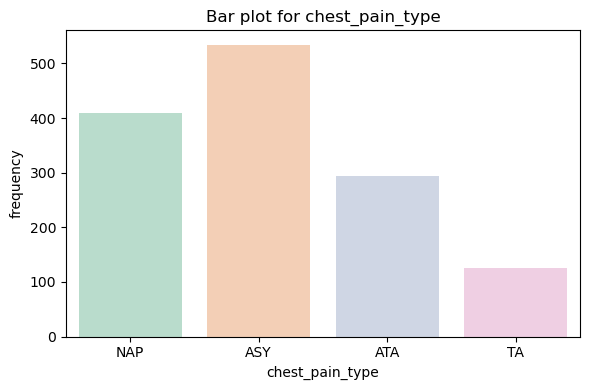

chest_pain_type
ASY    534
NAP    410
ATA    294
TA     125
Name: count, dtype: int64


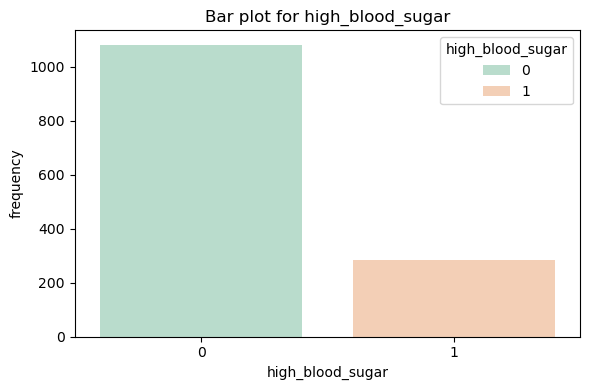

high_blood_sugar
0    1081
1     282
Name: count, dtype: int64


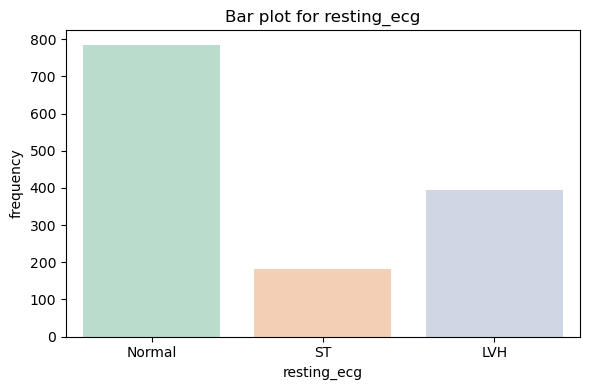

resting_ecg
Normal    785
LVH       395
ST        183
Name: count, dtype: int64


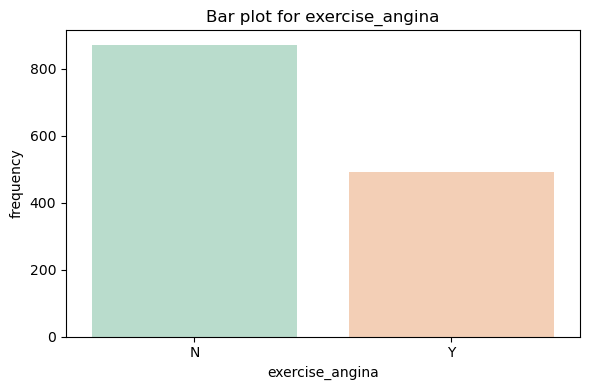

exercise_angina
N    872
Y    491
Name: count, dtype: int64


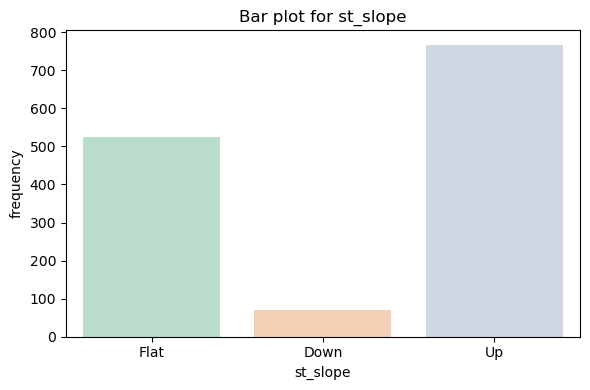

st_slope
Up      767
Flat    525
Down     71
Name: count, dtype: int64


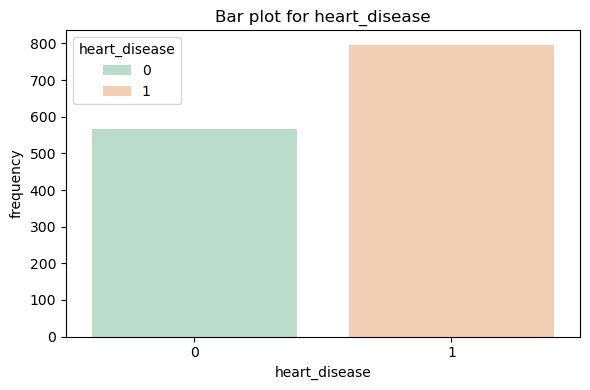

heart_disease
1    796
0    567
Name: count, dtype: int64


In [821]:
for column in ['gender', 'chest_pain_type', 'high_blood_sugar', 'resting_ecg', 'exercise_angina', 'st_slope', 'heart_disease']:
    plt.figure(figsize = (6, 4))
    
    sns.countplot(x = dataset[column], hue = dataset[column], palette = 'Pastel2')
    plt.ylabel('frequency')
    plt.title(f'Bar plot for {column}')
    plt.tight_layout()
    plt.show()
    
    print(dataset[column].value_counts())

### Comparison of the categorical variables relative to the target variable

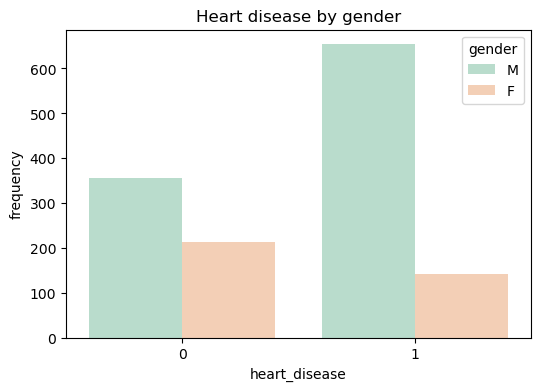

In [822]:
plt.figure(figsize = (6, 4))

sns.countplot(data = dataset, x = 'heart_disease', hue = dataset.gender, palette = 'Pastel2')
plt.xlabel('heart_disease')
plt.ylabel('frequency')
plt.title('Heart disease by gender')

plt.show()

In [823]:
round(dataset.groupby('gender')['heart_disease'].value_counts(normalize = True).unstack() * 100, 2)

heart_disease,0,1
gender,,
F,59.89,40.11
M,35.18,64.82


40% of the women in this dataset probably have heart disease.\
65% of the men in this datset probably have heart disease.

In [824]:
with_heart_disease = dataset[dataset.heart_disease == 1]
most_risk_ages = with_heart_disease['age'].value_counts().head(5)
mean_age = np.mean(most_risk_ages.index)

most_risk_ages

age
58    45
57    43
54    39
62    36
60    36
Name: count, dtype: int64

In [825]:
print(f"In the years around {round(mean_age)} there is the greatest risk for heart disease.")

In the years around 58 there is the greatest risk for heart disease.


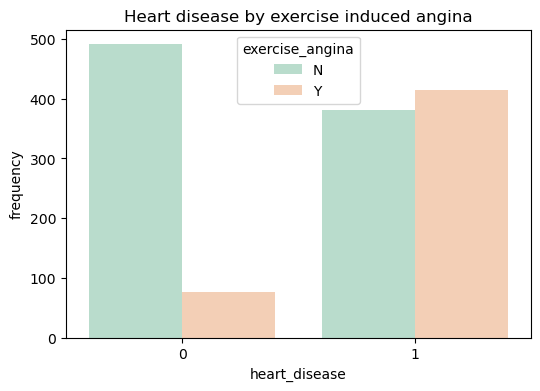

In [826]:
plt.figure(figsize = (6, 4))

sns.countplot(data = dataset, x = 'heart_disease', hue = dataset.exercise_angina, palette = 'Pastel2')
plt.xlabel('heart_disease')
plt.ylabel('frequency')
plt.title('Heart disease by exercise induced angina')

plt.show()

In [827]:
round(dataset.groupby('exercise_angina')['heart_disease'].value_counts(normalize = True).unstack() * 100, 2)

heart_disease,0,1
exercise_angina,,
N,56.31,43.69
Y,15.48,84.52


84% of the people with exercise induced angina have heart disease.

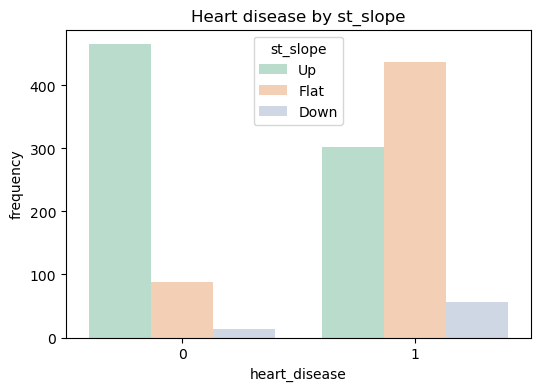

In [828]:
plt.figure(figsize = (6, 4))

sns.countplot(data = dataset, x = 'heart_disease', hue = dataset.st_slope, palette = 'Pastel2')
plt.xlabel('heart_disease')
plt.ylabel('frequency')
plt.title('Heart disease by st_slope')

plt.show()

The st_slope refers to the slope of the ST segment during a peak exercise test on an electrocardiogram. It reflects how the heart responds to exercise. This metric is used to assess heart function. \
Up: The ST segment slopes upward, indicating better heart function. \
Flat: The ST segment remains level, which may indicate potential heart issues. \
Down: The ST segment slopes downward, often associated with possible heart problems like ischemia.

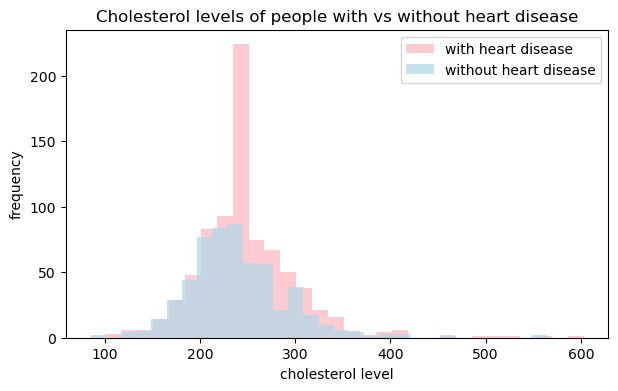

In [829]:
without_heart_disease = dataset[dataset['heart_disease'] == 0]

plt.figure(figsize = (7, 4))
plt.hist(with_heart_disease['cholesterol'], bins = 30, label = 'with heart disease', alpha = 0.7, color = 'lightpink')
plt.hist(without_heart_disease['cholesterol'], bins = 30, label = 'without heart disease', alpha = 0.7, color = 'lightblue')
plt.xlabel('cholesterol level')
plt.ylabel('frequency')
plt.title('Cholesterol levels of people with vs without heart disease')

plt.legend()
plt.show()

In [830]:
print(f"Average cholesterol of people with heart disease = {round(dataset[dataset.heart_disease == 1].cholesterol.mean())}")
print(f"Average cholesterol of people without heart disease = {round(dataset[dataset.heart_disease == 0].cholesterol.mean())}")

Average cholesterol of people with heart disease = 250
Average cholesterol of people without heart disease = 240


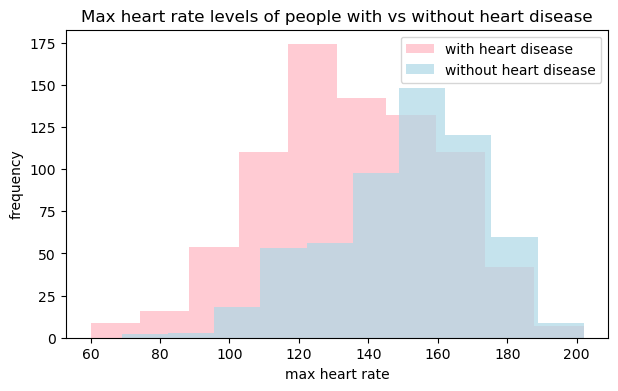

In [831]:
plt.figure(figsize = (7, 4))

plt.hist(with_heart_disease['max_heart_rate'], label = 'with heart disease', alpha = 0.7, color = 'lightpink')
plt.hist(without_heart_disease['max_heart_rate'], label = 'without heart disease', alpha = 0.7, color = 'lightblue')
plt.xlabel('max heart rate')
plt.ylabel('frequency')
plt.title('Max heart rate levels of people with vs without heart disease')
plt.legend()

plt.show()

In [832]:
print(f"Average max heart rate of people with heart disease = {round(dataset[dataset.heart_disease == 1].max_heart_rate.mean())}")
print(f"Average max heart rate of people without heart disease = {round(dataset[dataset.heart_disease == 0].max_heart_rate.mean())}")

Average max heart rate of people with heart disease = 135
Average max heart rate of people without heart disease = 151


People with heart disease have lower maximum heart rate, maybe because they are not so energetic and it's more difficult for them to move.

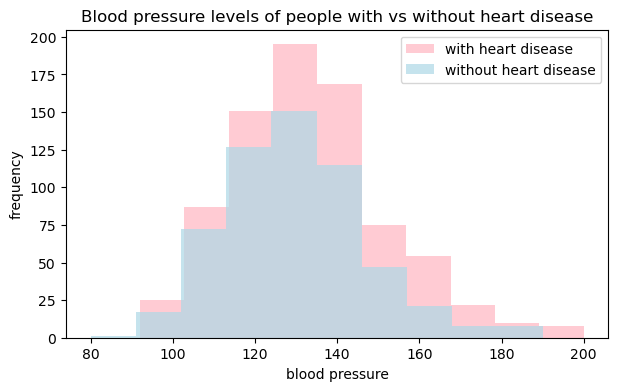

In [833]:
plt.figure(figsize = (7, 4))

plt.hist(with_heart_disease['blood_pressure'], label = 'with heart disease', alpha = 0.7, color = 'lightpink')
plt.hist(without_heart_disease['blood_pressure'], label = 'without heart disease', alpha = 0.7, color = 'lightblue')
plt.xlabel('blood pressure')
plt.ylabel('frequency')
plt.title('Blood pressure levels of people with vs without heart disease')
plt.legend()

plt.show()

In [834]:
print(f"Average blood pressure of people with heart disease = {round(dataset[dataset.heart_disease == 1].blood_pressure.mean())}")
print(f"Average blood pressure of people without heart disease = {round(dataset[dataset.heart_disease == 0].blood_pressure.mean())}")

Average blood pressure of people with heart disease = 133
Average blood pressure of people without heart disease = 130


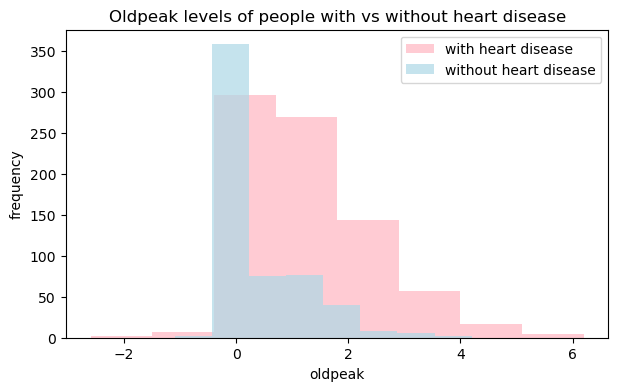

In [838]:
plt.figure(figsize = (7, 4))

plt.hist(dataset[dataset['heart_disease'] == 1].oldpeak, bins = 8, label = 'with heart disease', alpha = 0.7, color = 'lightpink')
plt.hist(dataset[dataset['heart_disease'] == 0].oldpeak, bins = 8, label = 'without heart disease', alpha = 0.7, color = 'lightblue')
plt.xlabel('oldpeak')
plt.ylabel('frequency')
plt.title('Oldpeak levels of people with vs without heart disease')
plt.legend()

plt.show()

In [1110]:
dataset[dataset.heart_disease == 1].oldpeak.mean()

1.2043969849246232

In [1112]:
dataset[dataset.heart_disease == 0].oldpeak.mean()

0.45185185185185195

Columns cholesterol, blood_pressure and oldpeak have a slight positive skew (right tail). The column max_heart_rate has a slight negative skew (left tail).

### Target exploration

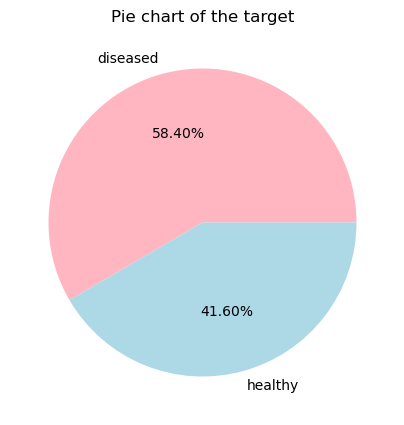

heart_disease
1    796
0    567
Name: count, dtype: int64


In [840]:
value_counts_target = dataset.heart_disease.value_counts()
plt.figure(figsize = (5, 5))

plt.pie(value_counts_target, labels = ["diseased", "healthy"], autopct = '%1.2f%%', colors = ['lightpink', 'lightblue'])
plt.title('Pie chart of the target')
plt.show()

print(value_counts_target)

In [841]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1363 non-null   int64  
 1   gender            1363 non-null   object 
 2   chest_pain_type   1363 non-null   object 
 3   blood_pressure    1363 non-null   float64
 4   cholesterol       1363 non-null   float64
 5   high_blood_sugar  1363 non-null   int64  
 6   resting_ecg       1363 non-null   object 
 7   max_heart_rate    1363 non-null   int64  
 8   exercise_angina   1363 non-null   object 
 9   oldpeak           1363 non-null   float64
 10  st_slope          1363 non-null   object 
 11  heart_disease     1363 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 127.9+ KB


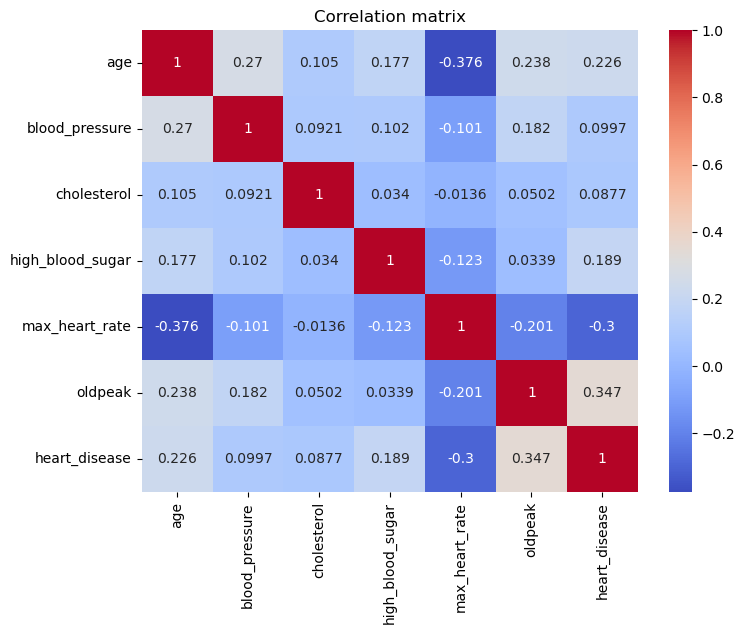

In [842]:
correlation_matrix = dataset.select_dtypes(include = ['int64', 'float64']).corr()

plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.3g')
plt.title('Correlation matrix')

plt.show()

## Hyperparameter optimization and model selection

### Train test split

In [929]:
dataset.shape

(1363, 12)

In [930]:
attributes = dataset.drop('heart_disease', axis = 1)
target = dataset['heart_disease']

attrs_train, attrs_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size = 0.25,
    random_state = 42, 
    stratify = target) 

### Pipeline

Models that i will use are: Logistic Regression, Decision tree, RandomForest, XGBoost, SVM. Decision Tree and Random Forest split data based on conditions rather than distances. But Logistic regression uses a linear decision boundary and SVM uses distance-based metrics, so feature scaling is important.

### Data preprocessing

In [310]:
# Log transformation for columns cholesterol and blood_pressure, because they have positive skew

# preprocessor = ColumnTransformer(
#     transformers = [
#         ('cat', OneHotEncoder(drop = 'first', sparse_output = False), ['gender', 'exercise_angina']),
#         ('mcat', OneHotEncoder(drop = "first", categories = [['ATA', 'NAP', 'ASY', 'TA']]), ['chest_pain_type']),
#         ('ord', OrdinalEncoder(categories = [
#             ['Normal', 'ST', 'LVH'],                    # for resting_ecg
#             ['Normal', 'Mild', 'Severe', 'Critical'],   # for oldpeak
#             ['Up', 'Flat', 'Down']                      # for st_slope
#         ]), ['resting_ecg', 'oldpeak', 'st_slope']),
#         ('log_transform', FunctionTransformer(np.log1p), ['blood_pressure', 'cholesterol']),
#         ('scaling', StandardScaler(), ['blood_pressure', 'cholesterol', 'max_heart_rate', 'age']),
#         ('passthrough', 'passthrough', ['high_blood_sugar']),
#     ]
# )

# poor performance with these transformations

In [931]:
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first', sparse_output = False), ['gender', 'exercise_angina']),
        ('mcat', OneHotEncoder(drop = "first", categories = [['ATA', 'NAP', 'ASY', 'TA']]), ['chest_pain_type']),
        ('ord', OrdinalEncoder(categories = [['Normal', 'ST', 'LVH'], ['Up', 'Flat', 'Down']]), ['resting_ecg', 'st_slope']),
        ('scaling', StandardScaler(), ['blood_pressure', 'cholesterol', 'max_heart_rate', 'age', 'oldpeak']),
        ('passthrough', 'passthrough', ['high_blood_sugar']),
    ]
)

In [932]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['gender', 'exercise_angina']),
                                ('mcat',
                                 OneHotEncoder(categories=[['ATA', 'NAP', 'ASY',
                                                            'TA']],
                                               drop='first'),
                                 ['chest_pain_type']),
                                ('ord',
                                 OrdinalEncoder(categories=[['Normal', 'ST',
                                                             'LVH'],
                                                            ['Up', 'Flat',
                                                             'Down']]),
                                 ['resting_ecg', 'st_slope']),
                                ('scaling', StandardScaler(),
                                 ['blood_pressure', 'cholesterol',
                                  'max_heart_rate', 'age', 'oldpeak']),
                                ('passthrough', 'passthrough',
                                 ['high_blood_sugar'])])

There are class imbalane in the target, so i use SMOTE.

In [933]:
def objective(trial):
    model_type = trial.suggest_categorical('classifier', ['DecisionTree', 'LogisticRegression', 'RandomForest', 'XGBoost', 'SVM'])
    
    if model_type == 'DecisionTree':
        classifier = DecisionTreeClassifier(
            max_depth = trial.suggest_int('max_depth', 2, 15),
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5),
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state = 42
        )  

    elif model_type == 'LogisticRegression':
        penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
        classifier = LogisticRegression(
            C = trial.suggest_float('C', 1e-2, 1e2, log = True),
            penalty = penalty,
            l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None,
            max_iter = 1000,
            solver = 'saga',
            class_weight = 'balanced',
            random_state = 42
        )

    elif model_type == 'RandomForest':
        classifier = RandomForestClassifier(
            max_depth = trial.suggest_int('max_depth', 2, 30),
            n_estimators = trial.suggest_int('n_estimators', 50, 500),
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5),
            class_weight = 'balanced',
            random_state = 42
        ) 
        
    elif model_type == 'XGBoost':
        classifier = XGBClassifier(
            max_depth = trial.suggest_int('max_depth', 2, 30),
            gamma = trial.suggest_float('gamma', 0, 5),
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log = True),
            n_estimators = trial.suggest_int('n_estimators', 50, 500),
            subsample = trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0),
            reg_alpha = trial.suggest_float('reg_alpha', 0, 10), 
            reg_lambda = trial.suggest_float('reg_lambda', 0, 10),
            random_state = 42
        )
        
    elif model_type == 'SVM':
        classifier = SVC(
            C = trial.suggest_float("C", 1e-4, 1e2, log = True),
            kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
            probability= True,
            random_state = 42
        )
        
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(sampling_strategy = 'minority', random_state = 42)),
        ('classifier', classifier),
    ])

    scoring = {'roc_auc': 'roc_auc', 'f1': 'f1', 'accuracy': 'accuracy'}

    scores = cross_validate(pipeline, attrs_train, target_train, cv = 5, scoring = scoring, return_train_score=False, return_estimator=True)

    preds = cross_val_predict(pipeline, attrs_train, target_train, cv = 5)
    cm = confusion_matrix(target_train, preds)
    
    trial.set_user_attr('roc_auc', scores['test_roc_auc'].mean())
    trial.set_user_attr('f1_score', scores['test_f1'].mean())
    trial.set_user_attr('accuracy', scores['test_accuracy'].mean())
    trial.set_user_attr('confusion_matrix', np.array2string(cm))

    return scores['test_roc_auc'].mean()


study = optuna.create_study(study_name = 'models_optimization', direction = 'maximize')
study.optimize(objective, n_trials = 200)
print(f"Best parameters: {study.best_params}\nwith optimization score: roc_auc = {study.best_value}")
best_trial = study.best_trial

[I 2024-11-21 12:43:52,879] A new study created in memory with name: models_optimization
[I 2024-11-21 12:43:54,141] Trial 0 finished with value: 0.8266200362497941 and parameters: {'classifier': 'XGBoost', 'max_depth': 29, 'gamma': 0.052170196788914325, 'learning_rate': 0.011984821783016733, 'n_estimators': 81, 'subsample': 0.8337327776824617, 'colsample_bytree': 0.9814225365192237, 'reg_alpha': 1.3814451818813656, 'reg_lambda': 2.14665390223494}. Best is trial 0 with value: 0.8266200362497941.
[I 2024-11-21 12:43:56,315] Trial 1 finished with value: 0.7793999835228209 and parameters: {'classifier': 'SVM', 'C': 7.958525113638268, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8266200362497941.
[I 2024-11-21 12:43:56,999] Trial 2 finished with value: 0.844582303509639 and parameters: {'classifier': 'XGBoost', 'max_depth': 10, 'gamma': 4.911864134096416, 'learning_rate': 0.4296435418256435, 'n_estimators': 249, 'subsample': 0.6122089226663849, 'colsample_bytree': 0.8451263564610842, 'r

Best parameters: {'classifier': 'XGBoost', 'max_depth': 23, 'gamma': 2.2913735999119655, 'learning_rate': 0.08200183136488076, 'n_estimators': 498, 'subsample': 0.6583574360283885, 'colsample_bytree': 0.8676376168423863, 'reg_alpha': 3.092696389671763, 'reg_lambda': 0.004332345233016177}
with optimization score: roc_auc = 0.8498337452628111


In [1113]:
best_params = {}

for trial in study.trials:
    classifier = trial.params['classifier']
    if classifier not in best_params or trial.value > best_params[classifier]['score']:
        best_params[classifier] = {
            'params': trial.params, 
            'score': trial.value,
            'f1_score': trial.user_attrs['f1_score'],
            'accuracy': trial.user_attrs['accuracy'],
            'cm': trial.user_attrs['confusion_matrix']
        }

for classifier, result in best_params.items():
    print(f"Classifier: {classifier}\nBest parameters: {result['params']}\nRoc_auc score: {result['score']}")
    print(f"F1-score: {result['f1_score']}\nAccuracy: {result['accuracy']}\nConfusion_matrix:\n {result['cm']}\n")

Classifier: XGBoost
Best parameters: {'classifier': 'XGBoost', 'max_depth': 23, 'gamma': 2.2913735999119655, 'learning_rate': 0.08200183136488076, 'n_estimators': 498, 'subsample': 0.6583574360283885, 'colsample_bytree': 0.8676376168423863, 'reg_alpha': 3.092696389671763, 'reg_lambda': 0.004332345233016177}
Roc_auc score: 0.8498337452628111
F1-score: 0.7941950104506441
Accuracy: 0.7661453849832617
Confusion_matrix:
 [[321 104]
 [135 462]]

Classifier: SVM
Best parameters: {'classifier': 'SVM', 'C': 0.013184155787493629, 'kernel': 'linear'}
Roc_auc score: 0.8289719064096227
F1-score: 0.7604713079560742
Accuracy: 0.744624581539933
Confusion_matrix:
 [[346  79]
 [182 415]]

Classifier: RandomForest
Best parameters: {'classifier': 'RandomForest', 'max_depth': 3, 'n_estimators': 464, 'min_samples_split': 3, 'min_samples_leaf': 3}
Roc_auc score: 0.8349697643763389
F1-score: 0.7647701862836151
Accuracy: 0.7465758010521281
Confusion_matrix:
 [[340  85]
 [174 423]]

Classifier: DecisionTree
Bes

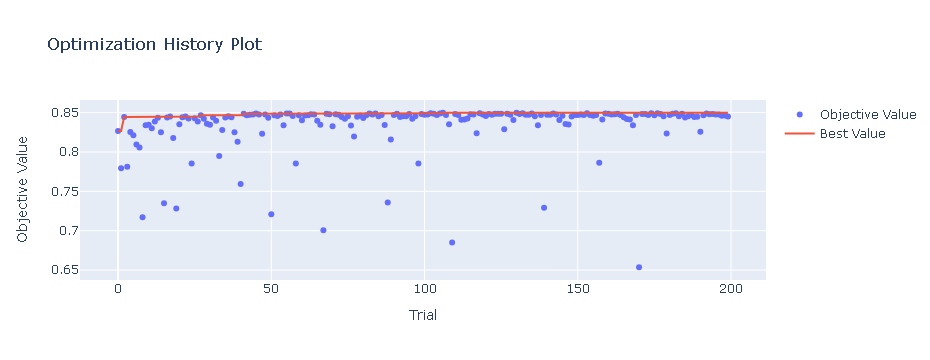

In [1114]:
plot_optimization_history(study).show()

## Training and evaluation

In [1115]:
def train_and_plot_roc(models_params, X_train, y_train, X_test, y_test, preprocessor):
    plt.figure(figsize = (8, 6))

    for model_name, model_data in models_params.items():
        params = model_data['params']
        classifier_type = params.pop('classifier')

        if classifier_type == 'RandomForest':
            model = RandomForestClassifier(**params, class_weight = 'balanced', random_state = 42)
        elif classifier_type == 'XGBoost':
            model = XGBClassifier(**params, random_state = 42)
        elif classifier_type == 'SVM':
            model = SVC(**params, probability = True, random_state = 42)
        elif classifier_type == 'DecisionTree':
            model = DecisionTreeClassifier(**params, random_state = 42)
        elif classifier_type == 'LogisticRegression':
            model = LogisticRegression(**params, solver = 'saga', class_weight = 'balanced', max_iter = 1000, random_state = 42)

        final_pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(sampling_strategy = 'minority', random_state = 42)),
            ('classifier', model)
        ])

        final_pipeline.fit(X_train, y_train)
        y_probs = final_pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw = 2, label = f'{model_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC AUC comparison for different models', fontsize=14)
    plt.legend(loc = 'lower right', fontsize = 10)
    plt.grid(alpha = 0.3)
    plt.savefig('img/roc_curves.png')
    plt.show()

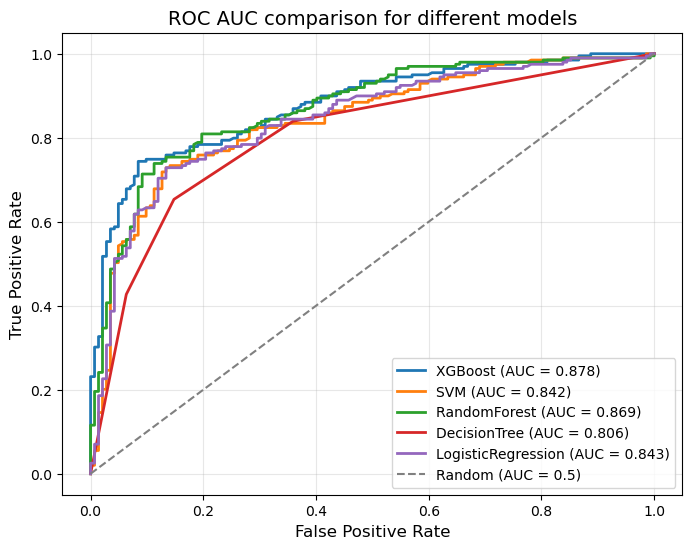

In [1116]:
train_and_plot_roc(best_params, attrs_train, target_train, attrs_test, target_test, preprocessor)

## XGBoost

Model performance on test set:
Accuracy: 0.7918
F1-score: 0.8117
Recall: 0.7688
Precision: 0.8596
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       142
           1       0.86      0.77      0.81       199

    accuracy                           0.79       341
   macro avg       0.79      0.80      0.79       341
weighted avg       0.80      0.79      0.79       341



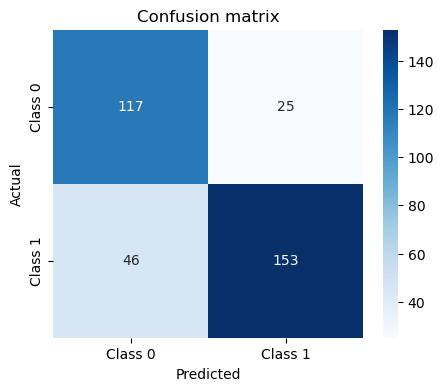

In [1118]:
params = best_params['XGBoost']['params']
xgb_model = XGBClassifier(**params, random_state = 42)

final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state = 42)),
    ('classifier', xgb_model)
])

final_pipeline.fit(attrs_train, target_train)
test_preds = final_pipeline.predict(attrs_test)

accuracy = accuracy_score(target_test, test_preds)
f1 = f1_score(target_test, test_preds)
recall = recall_score(target_test, test_preds)
precision = precision_score(target_test, test_preds)
cm = confusion_matrix(target_test, test_preds)
report = classification_report(target_test, test_preds)

print(f"Model performance on test set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Classification report:\n{report}")

plt.figure(figsize = (5, 4))
sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.savefig('img/cm.png')
plt.show()

True Negative = 117 , False Positive = 25 \
False Negative = 46 , True Positive = 153

## Feature importances

In [1119]:
feature_names = []
for transformer_name, transformer, columns in final_pipeline.named_steps['preprocessor'].transformers_:
    if transformer == 'drop':
        continue
    if hasattr(transformer, 'get_feature_names_out'): 
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

feature_names = pd.Series(feature_names)

xgb_model = final_pipeline.named_steps['classifier']
xgb_model.get_booster().feature_names = feature_names.tolist()

The gain is a measure of feature importance because it tells how much a feature contributes to improving the model's predictions: \
importance_type = 'gain' show which features contribute the most to model accuracy.

<Figure size 600x400 with 0 Axes>

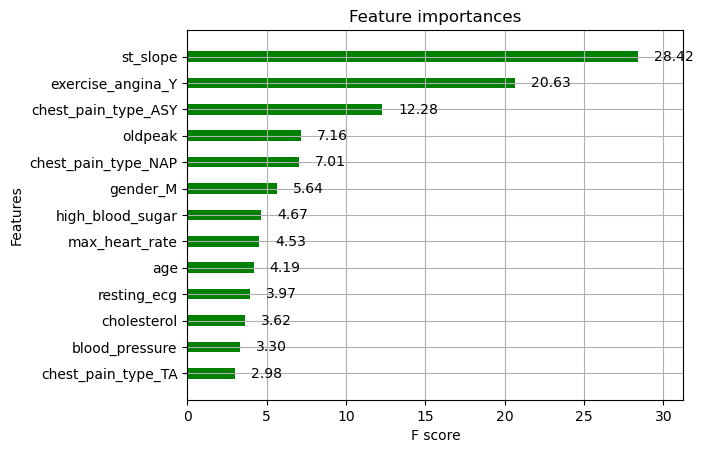

In [1123]:
plt.figure(figsize = (6, 4))
plot_importance(xgb_model, values_format = '{v:.2f}', height = 0.4, importance_type = 'gain', color = 'green', title='Feature importances')
plt.savefig('img/xgb_fi.png')
plt.show()

In [1026]:
# save the best model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)